In [1]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
# path of csv files
directory = r"D:\OneDrive - NITT\Custom_Download\ECG"

In [3]:
lst = []
for file in os.listdir(directory):
    fpath = os.path.join(directory,file)
    df_temp = pd.read_csv(fpath)
    df_temp['Channel'] = file.split('.')[0]
    lst.append(df_temp)

In [4]:
df_full = pd.concat(lst)

In [5]:
df_full['Label'] = df_full['Label'].replace(['ADHD','Non_ADHD'],[1,0])
df_full.drop(['Unnamed: 0','Filename'],axis=1,inplace=True)

In [6]:
df = pd.get_dummies(df_full)

In [7]:
X = df.drop('Label',axis=1)
y = df['Label']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# DecisionTreeClassifier

In [10]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       280
           1       0.71      0.68      0.70       295

    accuracy                           0.69       575
   macro avg       0.69      0.69      0.69       575
weighted avg       0.69      0.69      0.69       575



# RandomForestClassifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       280
           1       0.75      0.63      0.69       295

    accuracy                           0.70       575
   macro avg       0.71      0.71      0.70       575
weighted avg       0.71      0.70      0.70       575



# XGBClassifier

In [12]:
from xgboost import XGBClassifier

In [14]:
xgb = XGBClassifier(n_estimators=100,random_state = 42)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

In [15]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       280
           1       0.75      0.75      0.75       295

    accuracy                           0.74       575
   macro avg       0.74      0.74      0.74       575
weighted avg       0.74      0.74      0.74       575



In [16]:
importances = pd.DataFrame({
    'Feature': df.drop('Label', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
Relative_Beta,0.071930
Relative_Theta,0.068925
Relative_Delta,0.057508
Absolute_Delta,0.052156
Channel_Cz (1),0.050364
Absolute_Beta,0.049171
Channel_P3,0.048272
Channel_Fp1,0.048062
Absolute_Alpha,0.047385


<AxesSubplot:xlabel='Feature'>

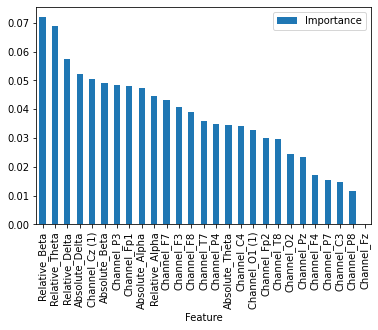

In [17]:
importances.plot.bar()

# Tuning

#  XGBOOST

In [20]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [21]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=100, 
                                   scoring='accuracy', n_jobs=-1, 
                   cv=3, verbose=3, random_state=1001 )

In [22]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_bin=256,...
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=0,
                                           num_parallel_tree=1,
                                           predictor='auto', random_state=42,
                                           reg_alpha=0, reg_lambda=1, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='accuracy', verbose=3)

In [23]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)


In [24]:
xgb_tuned = random_search.best_estimator_

In [25]:
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [26]:
y_pred_xgb = xgb_tuned.predict(X_test)

In [27]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       280
           1       0.72      0.74      0.73       295

    accuracy                           0.72       575
   macro avg       0.72      0.72      0.72       575
weighted avg       0.72      0.72      0.72       575



# DONT RUN THIS THIS CELL
- It will take huge time to execute

In [ ]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, 
                   cv=3, scoring='accuracy',verbose=3)
gs2.fit(X_train, y_train)

In [ ]:
gs2.best_params_

In [ ]:
xgb_tuned = gs2.best_estimator_
xgb_tuned.fit(X_train, y_train)
y_pred_xgb = xgb_tuned.predict(X_test)
print(classification_report(y_test,y_pred_xgb))

# TILL HERE DONT RUN

# DT Tuning

In [28]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }

gs2 = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid, n_jobs=-1, 
                   cv=3, scoring='accuracy',verbose=3)
gs2.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\avitr\anaconda3\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='accuracy', verbose=3)

In [29]:
dt_tuned = gs2.best_estimator_
dt_tuned.fit(X_train, y_train)
y_pred_dt = dt_tuned.predict(X_test)
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.75      0.47      0.58       280
           1       0.63      0.85      0.72       295

    accuracy                           0.66       575
   macro avg       0.69      0.66      0.65       575
weighted avg       0.69      0.66      0.65       575



C:\Users\avitr\anaconda3\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


# RF tuned

In [31]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }

gs2 = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid, n_jobs=-1, 
                   cv=3, scoring='accuracy',verbose=3)
gs2.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\avitr\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='accuracy', verbose=3)

In [32]:
rf_tuned = gs2.best_estimator_
rf_tuned.fit(X_train, y_train)
y_pred_rf = rf_tuned.predict(X_test)
print(classification_report(y_test,y_pred_rf))

C:\Users\avitr\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       0.74      0.68      0.71       280
           1       0.72      0.78      0.75       295

    accuracy                           0.73       575
   macro avg       0.73      0.73      0.73       575
weighted avg       0.73      0.73      0.73       575



# MLP

In [33]:
from sklearn.neural_network import MLPClassifier

In [34]:
clf = MLPClassifier(hidden_layer_sizes=(100,),random_state=42)
clf.fit(X_train, y_train)
y_pred_mlp = clf.predict(X_test)

C:\Users\avitr\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
print(classification_report(y_test,y_pred_mlp))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       280
           1       0.70      0.73      0.71       295

    accuracy                           0.70       575
   macro avg       0.70      0.70      0.70       575
weighted avg       0.70      0.70      0.70       575



# Attempt with only important features

In [36]:
XX = df[list(importances.index)[:-7]]

In [37]:
list(XX)

['Relative_Beta',
 'Relative_Theta',
 'Relative_Delta',
 'Absolute_Delta',
 'Channel_Cz (1)',
 'Absolute_Beta',
 'Channel_P3',
 'Channel_Fp1',
 'Absolute_Alpha',
 'Relative_Alpha',
 'Channel_F7',
 'Channel_F3',
 'Channel_F8',
 'Channel_T7',
 'Channel_P4',
 'Absolute_Theta',
 'Channel_C4',
 'Channel_O1 (1)',
 'Channel_Fp2',
 'Channel_T8']

In [38]:
from sklearn.model_selection import train_test_split
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, y, test_size = 0.25, random_state = 0)

In [39]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
XX_train = sc.fit_transform(XX_train)
XX_test = sc.transform(XX_test)

In [40]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(XX_train, y_train)
preds = xgb.predict(XX_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       280
           1       0.73      0.75      0.74       295

    accuracy                           0.73       575
   macro avg       0.73      0.73      0.73       575
weighted avg       0.73      0.73      0.73       575

